<a href="https://colab.research.google.com/github/Amin-Tgz/Tensorflow-Object-Detection-API-google-colab/blob/master/Use_Tensorflow_Object_Detection_API_in_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Object Detection Demo


Welcome to the object detection inference walkthrough! This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the installation instructions before you start.

## Installing necessary packages to run Tensorflow-Object Detetion_API in colab

* install protobuf and cython
* clone tensoflow models github
* build protobuf
* at the end test installation, so you must see pass 13 test in a short time

In [1]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
#!pip install jupyter
#!pip install matplotlib

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

.W0223 05:51:06.879596 140336981501824 deprecation.py:323] From /content/models/research/object_detection/anchor_generators/grid_anchor_generator.py:59: to_float (from tensorflow.python.ops.ma


## Imports


* remove check tf version , by default last version installed on colab



In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

print('tensorflow version = ',tf.__version__)

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


tensorflow version =  1.13.0-rc1


* change directory to use utils 

In [3]:
!pwd

/content/models/research


In [4]:
%cd ./object_detection/

from utils import label_map_util

from utils import visualization_utils as vis_util

/content/models/research/object_detection


In [0]:
# This is needed to display the images.
%matplotlib inline

## Model preparation

Any model exported using the **export_inference_graph.py** tool can be loaded here simply by changing **PATH_TO_FROZEN_GRAPH** to point to a new *.pb file*.

By default we use an "**SSD with Mobilenet**" model here. See the detection model zoo for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

### copy model name from model download link
[Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models)



![Link of Models](https://drive.google.com/uc?export=view&id=1Xi6sEQzzT6k4H6dN7ICk-am0qoVfb3En)

In [0]:
# What model to download.  (without .tar.gz)

MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
# MODEL_NAME = 'faster_rcnn_resnet101_ava_v2.1_2018_04_30'
# MODEL_NAME = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'


In [0]:
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

* download model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

* load model from graph ([what_is_a_tfgraph?](https://www.tensorflow.org/guide/graphs#what_is_a_tfgraph))

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


## Loading label map

Label maps map indices to **category names**, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a **dictionary mapping integers to appropriate string labels **would be fine

* by default use mscoco_label_map.pbtxt for coco dataset*


In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

* define function that load image as np.array

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Detection phase

### upload image to test_image folder
**Go to  ./models/research/object_detection/             directory  -->  right-click on test_images -->  upload**

![test_images](https://drive.google.com/uc?export=view&id=1PFYDd9yceM_a0QkylbJIk6dgo1xCLO_8)

In [14]:
!pwd
print('\nyou must see your uploaded images here\n')
!ls ./test_images/

/content/models/research/object_detection

you must see your uploaded images here

image1.jpg  image2.jpg	image_info.txt


* I add this section to read all jpg image in test_image folder

In [0]:
import glob
TEST_IMAGE_PATHS = []
for filename in glob.iglob('./test_images/*.jpg', recursive=True):
    TEST_IMAGE_PATHS.append(filename)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

* this code just read pictures that have 'image' at the first of their name so i comment it & and use above code!

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
#IMAGE_SIZE = (12, 8)

access ouput of model graph by operation name [get-a-tensorflow-tensor-by-name](https://www.aiworkbox.com/lessons/get-a-tensorflow-tensor-by-name)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

 ### A for loop that read all images in test_images path and feed into the network then show results

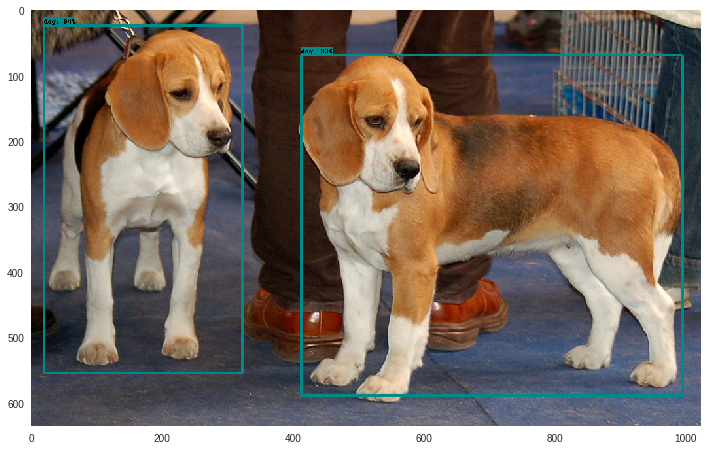

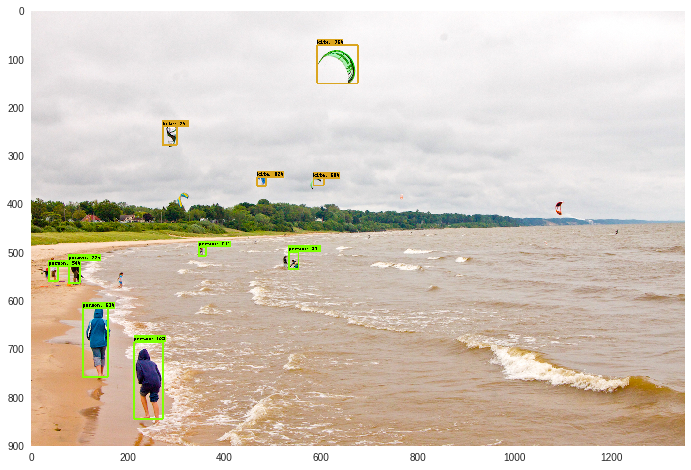

In [23]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.grid(False)